In [1]:
#For data loading and manipulation
import numpy as np
import pandas as pd

#For data visulisation
%matplotlib inline
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
import plotly as py

#For preprocssing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk import PorterStemmer,WordNetLemmatizer,wordpunct_tokenize,word_tokenize
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

#For Modelling
#pip install xgboost
#pip install lightgbm
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F


#For performance metrics, data spliting
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay,
                             precision_score,accuracy_score,
                             recall_score,matthews_corrcoef,precision_recall_curve)

#For Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Utilities
import warnings
warnings.filterwarnings('ignore')
import random
import os
import re

In [10]:
#Assert train.csv and test.csv are in working directory
train_dir = (os.getcwd() +'/train.csv' if 'train.csv' in os.listdir() else print('training set not in working directory'))
test_dir = (os.getcwd() +'/test.csv' if 'test.csv' in os.listdir() else print('testing set not in working directory'))

#Load datasets
df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)

In [120]:
class preprocesser:

    class LemmaTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()

        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


    class SteamTokenizer(object):
        def __init__(self):
            self.ps = PorterStemmer()

        def __call__(self, doc):
            return [self.ps.stem(t) for t in word_tokenize(doc)]
        
    def __init__(self):
        self.df = df_train
        self.lemma = self.LemmaTokenizer()
        self.steam  = self.SteamTokenizer()

        self.stem_vectorizer = TfidfVectorizer(max_features=400,
                                  tokenizer=self.steam)
        self.LemmaTokenizer = CountVectorizer(
            tokenizer=self.lemma,
            max_features=400
)

    def df_train_val_split(self, task, input, size):
        
        """
        task:Dependent variables can be choose from ['InformationTheory','ComputationalLinguistics','ComputerVision']

        input:independent variable that can be choose from ['title','abstract']

        size = select from ['full','sample'] to return either 10% or entire training set

        df_train_1k, df_val_1k: The first 1000 sample of the df_train set(900 inputs), and split 10% as validation set(100 inputs)

        df_train_all, df_val_all: The entire training data(112500 inputs) excluding 10% as validation set(12500 inputs)

        Return: X_train,X_val,y_train,y_val the training and validation value as list for both X and y variables
        """
        # Assert inputs meets function requirement
        assert input in [
            'title', 'abstract'], 'Please ensure input is choosen from title and abstract'
        assert task in ['InformationTheory', 'ComputationalLinguistics',
                        'ComputerVision'], 'Please ensure column name you wish to predict are correct'
        assert size in ['full', 'sample'], 'choose only full or sample dataset'

        if size == 'sample':
            df_1k = self.df.sample(1000).reset_index(drop=True)
            df_train_1k, df_val_1k = train_test_split(df_1k, test_size=.1)
            X_train = df_train_1k[input].tolist()
            X_val = df_val_1k[input].tolist()
            y_train = df_train_1k[task].tolist()
            y_val = df_val_1k[task].tolist()

        elif size == 'full':
            df_train_all, df_val_all = train_test_split(self.df, test_size=.1)
            X_train = df_train_all[input].tolist()
            X_val = df_val_all[input].tolist()
            y_train = df_train_all[task].tolist()
            y_val = df_val_all[task].tolist()
        return X_train, X_val, y_train, y_val


    def preprocess(self,text,method = 1):
        """
        text :raw text from dataset input
        method: int 1 or 2, refer to differetn preprocessing method
        Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
        Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer
        """
        assert method in [1,2],'Please select 1 or 2 only'
        STOPWORDS = set(stopwords.words('english'))

        # Lower
        text = text.lower()
        # Remove Special characters
        text = re.sub(r'\n','',text)
        # Spacing and filters
        text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip() 

        if method == 1:
            # Remove stopwords
            pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
            text = pattern.sub('', text)
            # Remove words in paranthesis
            text = re.sub(r'\([^)]*\)', '', text)

        else:
            pass

        return text
    
    def clean(self,task,size,input,method):
        """
        DOCUMENTS
        """
        X_train, X_val, y_train, y_val = self.df_train_val_split(task,input,size)

        if method == 1:
            X_train = [self.preprocess(i,method =1 ) for i in X_train]
            X_train = self.stem_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =1) for i in X_val]
            X_val = self.stem_vectorizer.fit_transform(X_val).astype(np.float64)
        elif method == 2:
            X_train = [self.preprocess(i,method =2 ) for i in X_train]
            X_train = self.LemmaTokenizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =2 ) for i in X_val]
            X_val = self.LemmaTokenizer.fit_transform(X_val).astype(np.float64)
        y_train = np.asarray(y_train)
        y_val =np.asanyarray(y_val)
        return X_train,X_val,y_train,y_val
    
    


In [121]:
preprocesser = preprocesser()
X_train,X_val,y_train,y_val = preprocesser.clean(task = 'ComputationalLinguistics',size = 'full',input = 'title',method = 2)

In [122]:
task =['InformationTheory', 'ComputationalLinguistics',
                        'ComputerVision']
method = ["1","2"]

size = ['full', 'sample']

In [124]:
models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'CatBoostClassifier': CatBoostClassifier(metric_period=600)
}
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in models.items():
     accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
best_model_name = cv_df.groupby('model_name')['accuracy'].mean().sort_values(ascending=False).index[0]

#Using Chatgpt to generate a sample searching grid
param_grid = {
    'AdaBoostClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'RandomForestClassifier': {
        'n_estimators': range(10, 500, 10),
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': range(1, 16, 2)
    },
    'XGBClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'max_depth': range(1, 16, 2),
        'subsample': np.arange(0, 1, 0.1),
        'colsample_bytree': np.arange(0, 1, 0.1)
    },
    'LGBMClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'max_depth': range(1, 16, 2),
        'subsample': np.arange(0, 1, 0.1),
        'colsample_bytree': np.arange(0, 1, 0.1),
        'feature_fraction':np.arange(0.1,1,0.1),
        'bagging_fraction':np.arange(0.1,1,0.1)
    },
    'BaggingClassifier': {
        'n_estimators': range(10, 500, 10),
        'max_samples': np.arange(0, 1, 0.1),
        'max_features': np.arange(0, 1, 0.1)
    },
    'CatBoostClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'depth': range(1, 16, 2),
        'max_leaves': [0, 64, 2],
        'l2_leaf_reg': [0, 10, 0.5],
        'subsample': np.arange(0, 1, 0.1)
    }
}


KeyboardInterrupt: 

In [ ]:
print(best_model_name)

CatBoostClassifier


In [ ]:
randomized_scv = RandomizedSearchCV(
        estimator=models[best_model_name],
        param_distributions=param_grid[best_model_name],
        n_iter=20,
        scoring='accuracy',
        cv=5,
        random_state=1,
        n_jobs=-1,
    ).fit(X_train,y_train)
best_model = randomized_scv.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_val)

0:	learn: 0.5842439	total: 148ms	remaining: 2m 27s
0:	learn: 0.5845139	total: 170ms	remaining: 2m 50s
0:	learn: 0.5843229	total: 188ms	remaining: 3m 7s
0:	learn: 0.5846244	total: 98.2ms	remaining: 1m 38s
0:	learn: 0.5842865	total: 140ms	remaining: 2m 19s
0:	learn: 0.6241706	total: 102ms	remaining: 1m 41s
0:	learn: 0.6241168	total: 149ms	remaining: 2m 29s
0:	learn: 0.6243000	total: 130ms	remaining: 2m 9s
600:	learn: 0.2299540	total: 24.7s	remaining: 16.4s
600:	learn: 0.2323506	total: 25.6s	remaining: 17s
600:	learn: 0.2317500	total: 36.4s	remaining: 24.1s
600:	learn: 0.2323203	total: 36.8s	remaining: 24.5s
600:	learn: 0.2317552	total: 37s	remaining: 24.6s
600:	learn: 0.2519981	total: 35.8s	remaining: 23.7s
600:	learn: 0.2516242	total: 35.8s	remaining: 23.8s
600:	learn: 0.2500110	total: 36s	remaining: 23.9s
999:	learn: 0.2212375	total: 40.6s	remaining: 0us
0:	learn: 0.6241456	total: 41.7ms	remaining: 41.7s
999:	learn: 0.2235409	total: 41.5s	remaining: 0us
0:	learn: 0.6243673	total: 24.5m

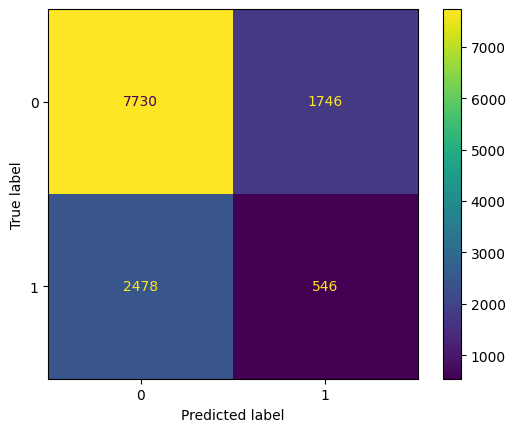

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

TypeError: list indices must be integers or slices, not str

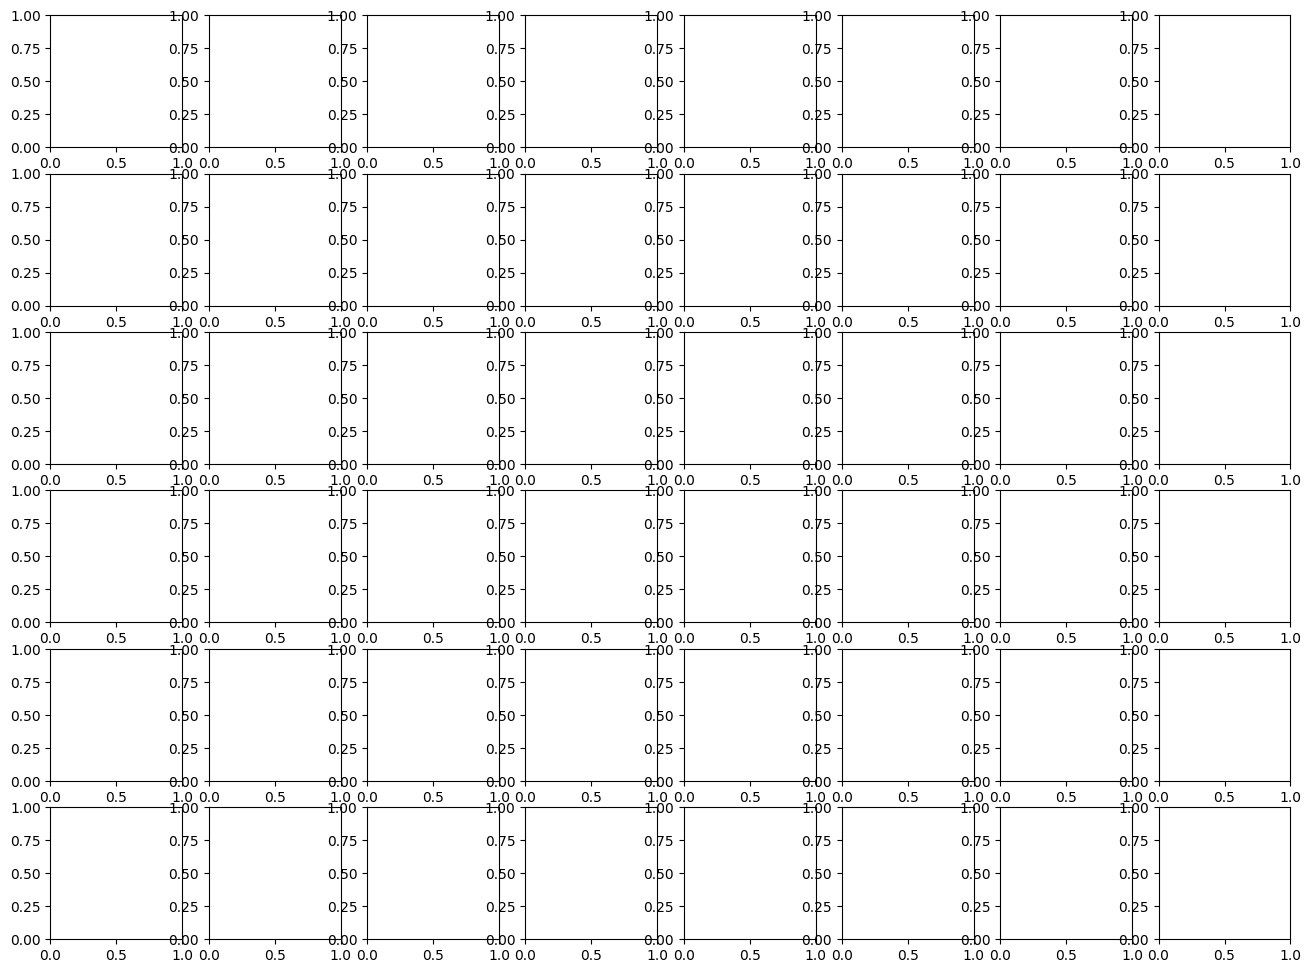

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Create the 6x8 subplot grid
fig, axs = plt.subplots(6, 8, figsize=(16, 12))

# Iterate over all combinations of task, method, and size
for i, t in enumerate(task):
    for j, m in enumerate(method):
        for k, s in enumerate(size):
            # Fit the best model on the training data
            best_model.fit(X_train[t][m][s], y_train[t][m][s])
            # Predict on the validation data
            y_pred = best_model.predict(X_val[t][m][s])
            # Compute the confusion matrix
            cm = confusion_matrix(y_val[t][m][s], y_pred)
            # Plot the confusion matrix on the corresponding subplot
            ax = axs[i, j*2+k]
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=ax)
            ax.set_title(f'{t}_{m}_{s}')

# Adjust subplot spacing
plt.tight_layout()
plt.show()
